# <center>Tarea 1 - Introducción a las Redes Neuronales Artificiales</center>
## <center> Ariel Sanhueza - 201173005-4 </center>
## <center> Diego Pérez - 201173xxx-y </center>

### Previo
Primero importaremos las bibliotecas necesarias para desarrollar la tarea.

In [1]:
%matplotlib inline
import numpy as np

from numpy.random import rand
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

from scipy.ndimage import uniform_filter
from scipy.misc import imread

import cPickle as pickle
import matplotlib
import matplotlib.pyplot as plt
import os

/Users/asanhuez/.miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.


Definimos las funciones entregadas con la tarea

In [6]:
#The next functions were slightly modified from the work of Alex Krizhevsky
#http://www.cs.toronto.edu/~kriz/cifar.html

def extract_features(array_imgs, feature_fns, verbose=False):
  """
  Given pixel data for images and several feature functions that can operate on
  single images, apply all feature functions to all images, concatenating the
  feature vectors for each image and storing the features for all images in
  a single matrix.

  Inputs:
  - array_imgs: N array of pixel data for N images.
  - feature_fns: List of k feature functions. The ith feature function should
    take as input an H x W x D array and return a (one-dimensional) array of
    length F_i. For CIFAR10, H=32, W=32, D=3
  - verbose: Boolean; if true, print progress.

  Returns:
  An array of shape (N, F_1 + ... + F_k) where each column is the concatenation
  of all features for a single image.
  """
  imgs = array_imgs.reshape(array_imgs.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float")
  print imgs.shape
  num_images = imgs.shape[0]
  if num_images == 0:
    return np.array([])

  # Use the first image to determine feature dimensions
  feature_dims = []
  first_image_features = []
  for feature_fn in feature_fns:
    feats = feature_fn(imgs[0].squeeze())
    assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
    feature_dims.append(feats.size)
    first_image_features.append(feats)

  # Now that we know the dimensions of the features, we can allocate a single
  # big array to store all features as columns.
  total_feature_dim = sum(feature_dims)
  imgs_features = np.zeros((num_images, total_feature_dim))
  imgs_features[0] = np.hstack(first_image_features).T

  # Extract features for the rest of the images.
  for i in xrange(1, num_images):
    idx = 0
    for feature_fn, feature_dim in zip(feature_fns, feature_dims):
      next_idx = idx + feature_dim
      imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
      idx = next_idx
    if verbose and i % 1000 == 0:
      print 'Done extracting features for %d / %d images' % (i, num_images)

  return imgs_features


def rgb2gray(rgb):
  """Convert RGB image to grayscale

    Parameters:
      rgb : RGB image

    Returns:
      gray : grayscale image
  
  """
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


def hog_features(im):
  """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """
  # convert rgb to grayscale if needed
  if im.ndim == 3:
    image = rgb2gray(im)
  else:
    image = np.at_least_2d(im)

  sx, sy = image.shape # image size
  orientations = 9 # number of gradient bins
  cx, cy = (8, 8) # pixels per cell

  gx = np.zeros(image.shape)
  gy = np.zeros(image.shape)
  gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
  gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
  grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

  n_cellsx = int(np.floor(sx / cx))  # number of cells in x
  n_cellsy = int(np.floor(sy / cy))  # number of cells in y
  # compute orientations integral images
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
  for i in range(orientations):
    # create new integral image for this orientation
    # isolate orientations in this range
    temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
    temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
    # select magnitudes for those orientations
    cond2 = temp_ori > 0
    temp_mag = np.where(cond2, grad_mag, 0)
    orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[cx/2::cx, cy/2::cy].T
  
  return orientation_histogram.ravel()


def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
  """
  Compute color histogram for an image using hue.

  Inputs:
  - im: H x W x C array of pixel data for an RGB image.
  - nbin: Number of histogram bins. (default: 10)
  - xmin: Minimum pixel value (default: 0)
  - xmax: Maximum pixel value (default: 255)
  - normalized: Whether to normalize the histogram (default: True)

  Returns:
    1D vector of length nbin giving the color histogram over the hue of the
    input image.
  """
  ndim = im.ndim
  bins = np.linspace(xmin, xmax, nbin+1)
  hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
  imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
  imhist = imhist * np.diff(bin_edges)

  # return histogram
  return imhist




## Problema 1

### a)
Primero generamos una función que genere $n$ pares (x,y), donde $x \in [-1,1]^2, y \in \{0,1\}$, como se sugirió en el enunciado.

In [2]:
def generate_data(n):
    # Generamos la matriz con los datos, de tamaño nx3
    ndata = 2*rand(n,3) - 1
    # Calculamos el valor que corresponde a y
    for i in range(n):
        if (ndata[i,0] > 0 and ndata[i,1] > 0) or (ndata[i,0] <= 0 and ndata[i,1] <= 0):
            ndata[i,2] = 0
        else:
            ndata[i,2] = 1
    return ndata

El problema se llama **XOR** pues la función de clasificación es la de la operación "OR-Exclusive". La separación sigue la misma lógica del XOR binario. Generamos los datos de entrenamiento y prueba para luego separarlos en la *data* de entrada y la data con los outputs deseados.

In [3]:
training_dt = generate_data(1000)
test_dt = generate_data(1000)

In [4]:
# Separamos la data en entrada y salida
X_training = training_dt[:,:2]
Y_training = training_dt[:,2]
X_test = test_dt[:,:2]
Y_test = test_dt[:,2]

### b)
Procedemos a generar neurona utilizando *keras* (como red neuronal de una capa oculta). Se mostrarán dos ejemplos donde se utilizarán dos funciones de activación: **lineal** y **sigmoidal**. Esto se hará para demostrar que independiente de los parámetros de la neurona, el problema no puede ser resuelto por ella. Los parámetros de la compilación son seteados de acuerdo a la página oficial de *keras* sobre un ejemplo de clasificador binario.

In [85]:
# Primero modelo
model_linear = Sequential()
model_linear.add(Dense(1, input_dim=2, activation='linear'))

In [86]:
# Compilamos
model_linear.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
# Entrenamos
model_linear.fit(X_training, Y_training, nb_epoch=300)

Epoch 1/300
1000/1000 [==============================] - 0s - loss: 4.9386 - acc: 0.4000     
Epoch 2/300
1000/1000 [==============================] - 0s - loss: 4.8518 - acc: 0.4100     
Epoch 3/300
1000/1000 [==============================] - 0s - loss: 4.7246 - acc: 0.4130     
Epoch 4/300
1000/1000 [==============================] - 0s - loss: 4.6671 - acc: 0.4190     
Epoch 5/300
1000/1000 [==============================] - 0s - loss: 4.6021 - acc: 0.4220     
Epoch 6/300
1000/1000 [==============================] - 0s - loss: 4.5465 - acc: 0.4270     
Epoch 7/300
1000/1000 [==============================] - 0s - loss: 4.4831 - acc: 0.4360     
Epoch 8/300
1000/1000 [==============================] - 0s - loss: 4.4120 - acc: 0.4450     
Epoch 9/300
1000/1000 [==============================] - 0s - loss: 4.3789 - acc: 0.4510     
Epoch 10/300
1000/1000 [==============================] - 0s - loss: 4.3601 - acc: 0.4580     
Epoch 11/300
1000/1000 [==============================] - 0

In [88]:
# Evaluamos el modelo
scores_linear = model_linear.evaluate(X_test, Y_test)
print "\nPrecisión de clasificación: {0:.2f}%".format(scores_linear[1]*100)

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 53.40%


In [77]:
# Segundo modelo
model_sig = Sequential()
model_sig.add(Dense(1, input_dim=2, activation='linear'))

In [78]:
# Compilamos
model_sig.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
# Entrenamos
model_sig.fit(X_training, Y_training, nb_epoch=300)

Epoch 1/300
1000/1000 [==============================] - 0s - loss: 5.1193 - acc: 0.3960     
Epoch 2/300
1000/1000 [==============================] - 0s - loss: 5.0944 - acc: 0.3990     
Epoch 3/300
1000/1000 [==============================] - 0s - loss: 5.0354 - acc: 0.4040     
Epoch 4/300
1000/1000 [==============================] - 0s - loss: 4.9580 - acc: 0.4090     
Epoch 5/300
1000/1000 [==============================] - 0s - loss: 4.8772 - acc: 0.4150     
Epoch 6/300
1000/1000 [==============================] - 0s - loss: 4.8240 - acc: 0.4240     
Epoch 7/300
1000/1000 [==============================] - 0s - loss: 4.7706 - acc: 0.4330     
Epoch 8/300
1000/1000 [==============================] - 0s - loss: 4.7670 - acc: 0.4380     
Epoch 9/300
1000/1000 [==============================] - 0s - loss: 4.6901 - acc: 0.4450     
Epoch 10/300
1000/1000 [==============================] - 0s - loss: 4.6533 - acc: 0.4450     
Epoch 11/300
1000/1000 [==============================] - 0

In [84]:
# Evaluamos el modelo
scores_sig = model_sig.evaluate(X_test, Y_test)
print "\nPrecisión de clasificación: {0:.2f}%".format(scores_sig[1]*100)

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 50.60%


Como se puede ver en ambos modelos, la precisión de clasificación en el conjunto de prueba es de aproximadamente un 50%. Esto se debe a que una sola neurona solo puede aproximar funciones lineales y por lo tanto solo puede resolver problemas linealmente separables. Dado que el problema **XOR** no es linealmente separable, utilizando una sola recta se tiene en aproximadamente un 50% de error teórico.

### c)
Ahora veremos para un modelo con 2 capas ocultas. La activación de las capas ocultas será una función sigmoidal. La capa de salida tendrá activación lineal.

In [89]:
# Creamos la red con sus parámetros
model_nn = Sequential()
model_nn.add(Dense(2, input_dim=2, activation='sigmoid'))
model_nn.add(Dense(1, activation='linear'))

In [90]:
# Compilamos
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
# Entrenamos
model_nn.fit(X_training, Y_training, nb_epoch=300)

Epoch 1/300
1000/1000 [==============================] - 0s - loss: 2.5264 - acc: 0.4930     
Epoch 2/300
1000/1000 [==============================] - 0s - loss: 1.5279 - acc: 0.4820     
Epoch 3/300
1000/1000 [==============================] - 0s - loss: 1.1806 - acc: 0.4720     
Epoch 4/300
1000/1000 [==============================] - 0s - loss: 0.9698 - acc: 0.4480     
Epoch 5/300
1000/1000 [==============================] - 0s - loss: 0.8675 - acc: 0.4170     
Epoch 6/300
1000/1000 [==============================] - 0s - loss: 0.8003 - acc: 0.3580     
Epoch 7/300
1000/1000 [==============================] - 0s - loss: 0.7561 - acc: 0.3320     
Epoch 8/300
1000/1000 [==============================] - 0s - loss: 0.7341 - acc: 0.3600     
Epoch 9/300
1000/1000 [==============================] - 0s - loss: 0.7240 - acc: 0.4020     
Epoch 10/300
1000/1000 [==============================] - 0s - loss: 0.7190 - acc: 0.4280     
Epoch 11/300
1000/1000 [==============================] - 0

In [92]:
# Evaluamos el modelo
scores_nn = model_nn.evaluate(X_test, Y_test)
print "\nPrecisión de clasificación: {0:.2f}%".format(scores_nn[1]*100)

  32/1000 [..............................] - ETA: 0s
Precisión de clasificación: 83.20%


Como se puede ver en este experimento utilizando el modelo descrito la precisió que se obtiene es de un 83.20% por lo que, dependiendo de los parámetros escogidos, el problema sí es resolvible mediante un perceptrón multicapas. Considerar que simplemente se usó un modelo de dos capas para hacer énfasis en que la mínima diferencia respecto al modelo de una neurona y de un percentrón multicapas genera una diferencia sustancial.

## Problema 2

### a)
Obtenemos los datos del link facilitado. Las líneas realizan:
* Línea 3: Se lee el CSV desde la URL entregada. Se marca el caracter ',' como separador de los datos y el parámetro names indica los nombres de cada columna.
* Línea 4: importa desde sklearn la función train_test_split que separa el dataset entre datos de entrenamiento y testing de forma aleatoria.
* Línea 5: Aplica train_test_split para separar en subconjuntos de entrenamiento y testeo.

In [2]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'

df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

HTTPError: HTTP Error 500: Internal Server Error

### b)

In [15]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(9), int64(5)
memory usage: 55.4 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.347826,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.083004,356.674032,12.653063,22.532806
std,8.601545,23.310593,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.280574,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.000000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.000000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.000000,391.440000,11.360000,21.200000
75%,3.677082,12.000000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.000000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### c)
Cuando los datos vienen en escalas muy diferentes puede llevar a que los datos con escalas más grandes logren mayor peso frente a los de menor escala (por ejemplo a la hora de calcular distancias). Normalizar los datos permite que todos los datos tengan un aporte "igualitario" a la hora de entrenar la red.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
# Datos de entrenamiento
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = df_train.pop('MEDV')
# Datos de testing
scaler = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
y_test_scaled = df_test.pop('MEDV')

### d)

In [17]:
model2_sigmoid = Sequential()
model2_sigmoid.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model2_sigmoid.add(Activation('sigmoid'))
model2_sigmoid.add(Dense(1, init='uniform'))
model2_sigmoid.add(Activation('linear'))

sgd = SGD(lr=0.2)
model2_sigmoid.compile(optimizer='sgd',loss='mean_squared_error')

hist_sigmoid = model2_sigmoid.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 100.1319 - val_loss: 43.6565
Epoch 2/300
379/379 [==============================] - 0s - loss: 31.1978 - val_loss: 33.2084
Epoch 3/300
379/379 [==============================] - 0s - loss: 21.6650 - val_loss: 27.3776
Epoch 4/300
379/379 [==============================] - 0s - loss: 17.2133 - val_loss: 22.9570
Epoch 5/300
379/379 [==============================] - 0s - loss: 14.5297 - val_loss: 23.7012
Epoch 6/300
379/379 [==============================] - 0s - loss: 12.4190 - val_loss: 20.6273
Epoch 7/300
379/379 [==============================] - 0s - loss: 10.7662 - val_loss: 16.2033
Epoch 8/300
379/379 [==============================] - 0s - loss: 9.2955 - val_loss: 17.6258
Epoch 9/300
379/379 [==============================] - 0s - loss: 9.4140 - val_loss: 12.4275
Epoch 10/300
379/379 [==============================] - 0s - loss: 7.4631 - val_loss: 11.2238
Epoch 11/300
37

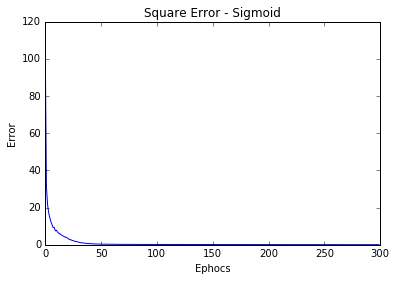

In [18]:
plt.plot(hist_sigmoid.history['loss'])
plt.title('Square Error - Sigmoid')
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

Se puede apreciar en el gráfico que el error disminuye en función del número de *epochs* que se utilicen pero de forma asintótica. Con un valor de aproximadamente 50 *epoch* se obtiene ya un error aproximadamente mínimo.

### e)

In [19]:
model2_relu = Sequential()
model2_relu.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
model2_relu.add(Activation('relu'))
model2_relu.add(Dense(1, init='uniform'))
model2_relu.add(Activation('linear'))

sgd = SGD(lr=0.2)
model2_relu.compile(optimizer='sgd',loss='mean_squared_error')

hist_relu = model2_relu.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 262.7564 - val_loss: 30.1954
Epoch 2/300
379/379 [==============================] - 0s - loss: 14.5123 - val_loss: 11.7285
Epoch 3/300
379/379 [==============================] - 0s - loss: 6.2734 - val_loss: 5.7712
Epoch 4/300
379/379 [==============================] - 0s - loss: 3.6331 - val_loss: 3.9208
Epoch 5/300
379/379 [==============================] - 0s - loss: 2.4617 - val_loss: 3.3576
Epoch 6/300
379/379 [==============================] - 0s - loss: 1.7917 - val_loss: 2.9982
Epoch 7/300
379/379 [==============================] - 0s - loss: 1.4611 - val_loss: 1.6607
Epoch 8/300
379/379 [==============================] - 0s - loss: 1.1252 - val_loss: 1.4218
Epoch 9/300
379/379 [==============================] - 0s - loss: 1.0055 - val_loss: 1.2230
Epoch 10/300
379/379 [==============================] - 0s - loss: 1.0434 - val_loss: 1.1703
Epoch 11/300
379/379 [======

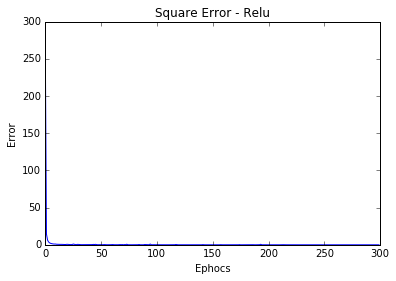

In [20]:
plt.plot(hist_relu.history['loss'])
plt.title("Square Error - Relu")
plt.xlabel('Ephocs')
plt.ylabel('Error')
plt.show()

Como se puede apreviar la diferencia más apreciable se nota en la cantidad de *epoch* necesarias para conseguir el error mínimo, el cual ocurre mucho antes de las 50 epochs.

### f)

In [22]:
# Generamos los n learning rates
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 264.2513 - val_loss: 46.4653
Epoch 2/300
379/379 [==============================] - 0s - loss: 15.7225 - val_loss: 11.6759
Epoch 3/300
379/379 [==============================] - 0s - loss: 6.0180 - val_loss: 7.6331
Epoch 4/300
379/379 [==============================] - 0s - loss: 3.6379 - val_loss: 4.1111
Epoch 5/300
379/379 [==============================] - 0s - loss: 2.3136 - val_loss: 3.7882
Epoch 6/300
379/379 [==============================] - 0s - loss: 1.6708 - val_loss: 2.0956
Epoch 7/300
379/379 [==============================] - 0s - loss: 1.3678 - val_loss: 2.4447
Epoch 8/300
379/379 [==============================] - 0s - loss: 1.0507 - val_loss: 1.2696
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.9201 - val_loss: 1.3544
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.8392 - val_loss: 1.2218
Epoch 11/300
379/379 [======

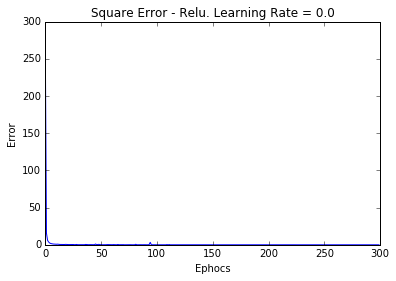

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 269.1262 - val_loss: 31.8957
Epoch 2/300
379/379 [==============================] - 0s - loss: 13.8449 - val_loss: 9.5667
Epoch 3/300
379/379 [==============================] - 0s - loss: 5.5062 - val_loss: 4.9394
Epoch 4/300
379/379 [==============================] - 0s - loss: 3.3789 - val_loss: 4.0013
Epoch 5/300
379/379 [==============================] - 0s - loss: 2.4478 - val_loss: 2.3800
Epoch 6/300
379/379 [==============================] - 0s - loss: 1.7087 - val_loss: 1.8040
Epoch 7/300
379/379 [==============================] - 0s - loss: 1.4103 - val_loss: 2.6229
Epoch 8/300
379/379 [==============================] - 0s - loss: 1.1712 - val_loss: 2.1090
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.9212 - val_loss: 1.1086
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.8974 - val_loss: 1.2584
Epoch 11/300
379/379 [=======

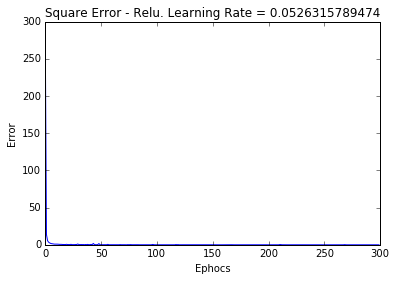

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 271.9430 - val_loss: 33.2757
Epoch 2/300
379/379 [==============================] - 0s - loss: 14.5835 - val_loss: 10.2473
Epoch 3/300
379/379 [==============================] - 0s - loss: 5.9477 - val_loss: 7.4569
Epoch 4/300
379/379 [==============================] - 0s - loss: 3.6278 - val_loss: 4.1853
Epoch 5/300
379/379 [==============================] - 0s - loss: 2.3231 - val_loss: 3.7971
Epoch 6/300
379/379 [==============================] - 0s - loss: 2.2200 - val_loss: 2.1209
Epoch 7/300
379/379 [==============================] - 0s - loss: 1.5043 - val_loss: 2.3724
Epoch 8/300
379/379 [==============================] - 0s - loss: 1.5622 - val_loss: 1.7071
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.9235 - val_loss: 1.2687
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.8240 - val_loss: 1.0101
Epoch 11/300
379/379 [======

ValueError: I/O operation on closed file

In [23]:
for lr in lear_rate:
    model_lr = Sequential()
    model_lr.add(Dense(200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model_lr.add(Activation('relu'))
    model_lr.add(Dense(1, init='uniform'))
    model_lr.add(Activation('linear'))

    sgd = SGD(lr=lr)
    model_lr.compile(optimizer='sgd',loss='mean_squared_error')

    hist_relu = model_lr.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    
    # Graficamos
    plt.plot(hist_relu.history['loss'])
    plt.title("Square Error - Relu. Learning Rate = {0}".format(lr))
    plt.xlabel('Ephocs')
    plt.ylabel('Error')
    plt.show()